In [21]:
from modsim import *
import math
import pandas as pd
from random import randint 

# Limeshare
![](https://media3.s-nbcnews.com/j/newscms/2018_44/2625546/181031-lime-scooter-mc-1124_a00349954036680c731079b7c08ae2d1.fit-760w.JPG)

## Below is our state with attributes:
- **number_of_scooters:** scooters deployed in region (~30)
- **av_batt_life:** the average battery life of number_of_scooters a value from (0-100)
- **size_of_region:** the square acres of a region (200-2000)
- **send_truck:** the hour when we send our truck to recharge all scooters (0-23)
- **delta_by_hour:** the change in av_batt_life in each hourly step

In [22]:
limeshare = State(number_of_scooters = 20, av_batt_life = 100, size_of_region = 200, send_truck = -1, delta_by_hour = [])
limeshare

,values
number_of_scooters,20
av_batt_life,100
size_of_region,200
send_truck,-1
delta_by_hour,[]


## step for the hour 
- simulates usage of scooters in a region for one hour 
- if the av_batt_life is < 20 calls for truck to recharge scooters

In [23]:
def step(state, hour):
#     find number of users per hour (rush hour = more users)
#     returns a num between (0, state.number_of_scooters)
    demand = calcDemand(state.number_of_scooters, hour)
    
#     find the average ride length per rider from demand (bigger region = higher av length of use)
#     returns a num between ~(10-60)
    length_of_use = calcAverageRide(state.size_of_region, demand)
    
#     calc change in battery 
    calcBattDelta(state, demand, length_of_use)
    
#   adds latest changes in av_batt_life
    state.delta_by_hour.append(state.av_batt_life)
    
#     find hour to send truck
    if(state.av_batt_life < 20 and state.send_truck == -1):
        sendTruck(state, hour)


## Calculate demand for scooters based on: 
- traffic times 
    - HIGH : going to work (8-10pm), lunch time (12-2pm), going home (4-6pm)
    - NUETRAL : early birds (6-8am), night outs (8pm-11pm)
    - LOW : all remaining times
- scooters in the area (this is a hard max) 
- randomize using round (say bad weather hour)


**Returns num of scooters with range (0, number_of_scooters)**
   - the lowest possible demand is zero and the highest is number of scooters int that region

In [24]:
def calcDemand(scooters, hour): 
    if hour >= 8 and hour < 10 or hour >= 12 and hour < 14 or hour >= 16 and hour < 18:
        return int(scooters/2) 
    elif hour == 6 or hour == 7 or hour >= 20 and hour < 23:  
        return int(scooters/3)
    else: 
        if hour == 0:
            return int(scooters/4) 
        else:
            return int(scooters/4)

## Caluculate average ride length of scooters used 

**factors the affect the ride length**
- area of region (the higher the area the longer the ride)
- demand (if there is more demand, chances are the rides are longer)

**Ranges for inputs**
- demand: ~30
- areas: 200 - 2000 acres

**returns average length scooters used for the hour with range (~10, ~60) min**
- check the test methods below 

In [25]:
def calcAverageRide(area, demand):
    return int(area/60) 

Test the method above with av demand of 30 scooters and area range 500-2k acres

In [26]:
print(calcAverageRide(500, 30), calcAverageRide(1000, 30), calcAverageRide(2000, 30))

8 16 33


## Calc changes in average battery life of region from demand 
We came up with a simple formula in class. The whole point of the fucntion is to check how much battery goes down from sccoter usage 

### CASE STUDY:
- lets say before method is called we have 20 scooters (s) in region with av battery life of 100 percent (c) 
- this means all the scooters in this regions is fully charged
- if let's say the demand is only 1 scooter (t) and we say that scooter charge after use goes down 10 percent (d)  
- then the average for all the scooters decreases by a little but exactly how much ?  
<br/>

#### The new average battery life of the region can be calculated by finding... 
- **batt_not_used:** The av of scooters that were'nt used times the charge 
    - so 19\*100 OR (s-t)\*c = 1900
- **batt_used:** the average of scooters that were used times the charge delta 
    - so 1\*90 OR t(c-d) = 90
- the new average of the region is thus 
    - (batt_not_used + batt_used) / s = (1900 + 90) / 20 = 99.5

THE FORMULA
- ((s-t)*c + t*(c- d)) / s
    

**Inputs range**
- state: as defined
- demand: same as inputs range for calcDemand() which is (0, state.number_of_scooters) or (0-120ish) for this model
- av_length_of_use: same as inputs range for calcAvRide() which is (~10, ~60)

In [27]:
def calcBattDelta(state, demand, av_length_of_use):
    s = state.number_of_scooters 
    c = state.av_batt_life
    t = demand
    d = (av_length_of_use / 60)*100
    
    state.av_batt_life =  math.floor(((s-t)*c + t*(c- d)) / s)
        

def sendTruck(state, hour):
    state.send_truck = hour;

## A day in a region with scooters
- simulates usage of scooters in a region for one day
- if we have found the hour to send truck, we have found what is needed and exit

In [28]:
def run_simulation(state, num_steps):     
    results = TimeSeries()
    for hour in range(num_steps):
        #  this is our line in the sand to prevent calculating after our desired purpose for the model has been found
        if(state.send_truck != -1):
            return
        step(state, hour)
        results[hour] = state.av_batt_life

In [29]:
limeshare = State(number_of_scooters = 20, av_batt_life = 100, size_of_region = 1000, send_truck = -1, delta_by_hour = [])
run_simulation(limeshare, 24)
limeshare

,values
number_of_scooters,20
av_batt_life,14
size_of_region,1000
send_truck,9
delta_by_hour,"[93, 86, 79, 72, 65, 58, 50, 42, 28, 14]"


## run_simulation A:  
#### variable *size_of_region*, fixed  *number_of_scooters*
- testing acres from 200 to 1000 in increments of 200
- tuple array ( region size, hour truck sent, length of batt delta array recorded, first batt delta recorded)
    - **if length of batt delta array recorded is 24**, that means that the entire day the av_batt > 20
- expectation : with larger region we need to send the truck earlier


In [30]:
def runModel():
#     sample range
    regions = linspace(200, 2000, 100)
    results = []
    for i in regions:
#         init state var
        limeshare = State(number_of_scooters = 30, av_batt_life = 100, size_of_region = round(i + 1), send_truck = -1, delta_by_hour = [])
        run_simulation(limeshare, 24)
#         store in tuple 
        data = (limeshare.size_of_region, limeshare.send_truck, len(limeshare.delta_by_hour), limeshare.delta_by_hour[0] )
        results.append(data)
    return results 

In [31]:
sample_regions = runModel()
# print length of batt delta array recorded
print("length of batt delta array recorded\n")
print([x[2] for x in sample_regions])


length of batt delta array recorded

[24, 24, 24, 24, 24, 24, 24, 24, 24, 22, 22, 22, 22, 21, 21, 21, 17, 17, 17, 16, 16, 16, 15, 15, 15, 15, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


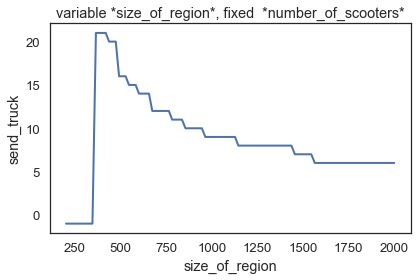

In [32]:
# graph to view our expectation
plot([x[0] for x in sample_regions], [x[1] for x in sample_regions], label='')
def decorate_limeshare():
    """Add a title and label the axes."""
    decorate(title='variable *size_of_region*, fixed  *number_of_scooters*',
             xlabel='size_of_region', 
             ylabel='send_truck')
decorate_limeshare()

## Results 
- expectations met! 

## Model with real data 
- below are the actual sizes of regions in acres within Queens

In [33]:
region_data = [("Forest Hills", 1664), 
                ("Jamaica", 1709), 
                ("Richmond Hill", 1171),
                ("Ozone Park",576),
                ("Queens Village", 1611),
                ("Astoria", 902),
                ("College Point", 1148),
                ("Woodside", 649)]

In [34]:
# print only the region names
print([x[0] for x in region_data])
# print the areas
print([x[1] for x in region_data])
# print tuple
print(region_data)


['Forest Hills', 'Jamaica', 'Richmond Hill', 'Ozone Park', 'Queens Village', 'Astoria', 'College Point', 'Woodside']
[1664, 1709, 1171, 576, 1611, 902, 1148, 649]
[('Forest Hills', 1664), ('Jamaica', 1709), ('Richmond Hill', 1171), ('Ozone Park', 576), ('Queens Village', 1611), ('Astoria', 902), ('College Point', 1148), ('Woodside', 649)]


#### sort tuple array by area 

In [35]:
region_data.sort(key=lambda tup: tup[1])
# print the areas
print([x[1] for x in region_data])
# print tuple
print(region_data)


[576, 649, 902, 1148, 1171, 1611, 1664, 1709]
[('Ozone Park', 576), ('Woodside', 649), ('Astoria', 902), ('College Point', 1148), ('Richmond Hill', 1171), ('Queens Village', 1611), ('Forest Hills', 1664), ('Jamaica', 1709)]


## run_simulation B:  
#### use real data to model which hour we send truck

In [36]:
def runModel():
    results = []
#   [x[1] for x in region_data] is the array containing the second values of our tuple (real areas)
    real_areas = [x[1] for x in region_data]
    for area in real_areas:
        limeshare = State(number_of_scooters = 30, av_batt_life = 100, size_of_region = area, send_truck = -1, delta_by_hour = [])
        run_simulation(limeshare, 24)
        data = (limeshare.size_of_region, limeshare.send_truck, len(limeshare.delta_by_hour))
        results.append(data)
    return results 

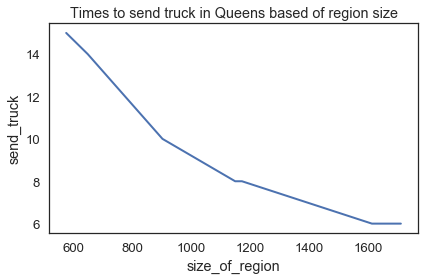

In [37]:
model_data = runModel()
plot([x[0] for x in model_data], [x[1] for x in model_data], label='')
def decorate_limeshare():
    """Add a title and label the axes."""
    decorate(title='Times to send truck in Queens based of region size',
             xlabel='size_of_region', 
             ylabel='send_truck')
decorate_limeshare()

In [38]:
print([x[0] for x in region_data], [x[1] for x in model_data])

['Ozone Park', 'Woodside', 'Astoria', 'College Point', 'Richmond Hill', 'Queens Village', 'Forest Hills', 'Jamaica'] [15, 14, 10, 8, 8, 6, 6, 6]


### MODEL RESULTS 
- for ozone park we send out truck at time 15
- for jamaica we send at time 6